<a href="https://colab.research.google.com/github/karen-chung/dissertation/blob/main/PatchTST_CNN_LSTM_CNN_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.kdnuggets.com/2020/07/r-squared-predictive-capacity-statistical-adequacy.html#:~:text=In%20neither%20of%20these%20cases,the%20predictive%20capacity%20of%20the

## Libraries & Dependencies

In [43]:
# !pip install scikit-learn pandas matplotlib seaborn numpy
# !pip install tensorflow
!pip install neuralforecast

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import numpy as np


from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
from sklearn.metrics import accuracy_score
from neuralforecast.losses.pytorch import GMM, DistributionLoss, MAE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.saving import load_model

import tensorflow as tf
import random
import os

# Adjust the display setting to show all columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Load Turbine Dataframes

In [45]:
impCols = ['# Date and time', 'Wind speed (m/s)', 'Long Term Wind (m/s)', 'Wind direction (°)', 'Nacelle position (°)', 'Vane position 1+2 (°)', 'Energy Export (kWh)', 'Energy Import (kWh)', 'Lost Production Total (kWh)', 'Power (kW)',
           'Reactive power (kvar)', 'Front bearing temperature (°C)', 'Rear bearing temperature (°C)', 'Stator temperature 1 (°C)', 'Nacelle ambient temperature (°C)', 'Nacelle temperature (°C)', 'Transformer temperature (°C)',
           'CPU temperature (°C)', 'Grid voltage (V)', 'Grid current (A)', 'Rotor speed (RPM)', 'Gearbox speed (RPM)', 'Yaw bearing angle (°)', 'Grid frequency (Hz)', 'Production Factor', 'Performance Index',
           'Investment Performance Ratio', 'Operating Performance Ratio', 'Metal particle count', 'Apparent power (kVA)' , 'Generator RPM (RPM)'] #

In [46]:
dfTRB1 = pd.read_csv('Turbine_Data_Kelmarsh_1_2022-01-01_-_2023-01-01_228.csv', skiprows=9, usecols=impCols)
dfTRB2 = pd.read_csv('Turbine_Data_Kelmarsh_2_2022-01-01_-_2023-01-01_229.csv', skiprows=9, usecols=impCols)
dfTRB3 = pd.read_csv('Turbine_Data_Kelmarsh_3_2022-01-01_-_2023-01-01_230.csv', skiprows=9, usecols=impCols)
dfTRB4 = pd.read_csv('Turbine_Data_Kelmarsh_4_2022-01-01_-_2023-01-01_231.csv', skiprows=9, usecols=impCols)
dfTRB5 = pd.read_csv('Turbine_Data_Kelmarsh_5_2022-01-01_-_2023-01-01_232.csv', skiprows=9, usecols=impCols)
dfTRB6 = pd.read_csv('Turbine_Data_Kelmarsh_6_2022-01-01_-_2023-01-01_233.csv', skiprows=9, usecols=impCols)

In [47]:
dfTRB1.isna().sum()

# Date and time                        0
Wind speed (m/s)                     554
Long Term Wind (m/s)                   0
Wind direction (°)                   550
Nacelle position (°)                 550
Vane position 1+2 (°)                593
Energy Export (kWh)                    6
Energy Import (kWh)                   67
Lost Production Total (kWh)            0
Power (kW)                           550
Reactive power (kvar)                550
Front bearing temperature (°C)       593
Rear bearing temperature (°C)        593
Stator temperature 1 (°C)            550
Nacelle ambient temperature (°C)     593
Nacelle temperature (°C)             593
Transformer temperature (°C)         593
CPU temperature (°C)                 550
Grid voltage (V)                     550
Grid current (A)                     550
Rotor speed (RPM)                    550
Generator RPM (RPM)                  550
Gearbox speed (RPM)                  550
Yaw bearing angle (°)                593
Grid frequency (Hz)                  550
Production Factor                      0
Performance Index                   2235
Investment Performance Ratio           0
Operating Performance Ratio         8027
Apparent power (kVA)                 550
Metal particle count                   0
dtype: int64

In [49]:
tarTurbine = 'Power (kW) Turbine_4'

## Data Preprocessing & Feature Engineering

### Combine Turbine Dataset

In [50]:
def combine_wind_turbine_data(dfs, turbine_names, datetime_col="# Date and time"):
    """
    Combines multiple dataframes from different wind turbines, renaming the columns dynamically
    to reflect the specific turbine, except for the datetime column.

    Parameters:
    - dfs: List of pandas DataFrames from different turbines.
    - turbine_names: List of turbine names corresponding to each DataFrame.
    - datetime_col: The name of the datetime column that should remain common.

    Returns:
    - combined_df: A single DataFrame with dynamically renamed columns.
    """
    # Create a list to store the renamed DataFrames
    renamed_dfs = []

    for df, turbine_name in zip(dfs, turbine_names):
        # Rename columns except for the datetime column
        renamed_df = df.rename(columns={col: f"{col} {turbine_name}" if col != datetime_col else col for col in df.columns})
        renamed_dfs.append(renamed_df)

    # Merge all DataFrames on the datetime column
    combined_df = pd.concat(renamed_dfs, axis=1)

    # Drop duplicate datetime columns if they exist after merging
    combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

    return combined_df

turbine_names = ["Turbine_1", "Turbine_2", "Turbine_3", "Turbine_4", "Turbine_5", "Turbine_6"]
comb_DF_TRB = combine_wind_turbine_data([dfTRB1, dfTRB2, dfTRB3, dfTRB4, dfTRB5, dfTRB6], turbine_names)

In [51]:
comb_DF_TRB.shape

(52560, 181)

In [52]:
comb_DF_TRB.head()

# Date and time  Wind speed (m/s) Turbine_1  \
0  2022-01-01 00:00:00                    6.781222   
1  2022-01-01 00:10:00                    6.936052   
2  2022-01-01 00:20:00                    7.294642   
3  2022-01-01 00:30:00                    8.080467   
4  2022-01-01 00:40:00                    7.021328   

   Long Term Wind (m/s) Turbine_1  Wind direction (°) Turbine_1  \
0                            7.21                    185.795348   
1                            7.21                    189.458687   
2                            7.21                    188.648729   
3                            7.21                    188.826550   
4                            7.21                    191.252213   

   Nacelle position (°) Turbine_1  Vane position 1+2 (°) Turbine_1  \
0                      193.731354                        -9.971973   
1                      193.731354                        -6.699598   
2                      193.731354                        -4.183767   
3                      193.731354                        -6.108515   
4                      193.731354                        -1.088158   

   Energy Export (kWh) Turbine_1  Energy Import (kWh) Turbine_1  \
0                          126.0                       0.001887   
1                          116.0                       0.001887   
2                          122.0                       0.001887   
3                          211.0                       0.001887   
4                          136.0                       0.001887   

   Lost Production Total (kWh) Turbine_1  Power (kW) Turbine_1  \
0                              10.818564            630.889598   
1                             -11.235055            809.339449   
2                              -5.118643            893.607333   
3                              26.933563            995.583734   
4                             -26.360199            926.519441   

   Reactive power (kvar) Turbine_1  Front bearing temperature (°C) Turbine_1  \
0                      -190.507286                                 73.852499   
1                      -235.626105                                 73.087500   
2                      -222.190602                                 72.187499   
3                      -240.734678                                 72.530000   
4                      -287.214456                                 73.570000   

   Rear bearing temperature (°C) Turbine_1  \
0                                70.157500   
1                                69.632499   
2                                68.932501   
3                                68.994999   
4                                69.842501   

   Stator temperature 1 (°C) Turbine_1  \
0                            63.590000   
1                            64.622500   
2                            65.120000   
3                            65.405000   
4                            62.717499   

   Nacelle ambient temperature (°C) Turbine_1  \
0                                     12.4775   
1                                     12.4925   
2                                     12.5225   
3                                     12.5700   
4                                     12.5925   

   Nacelle temperature (°C) Turbine_1  Transformer temperature (°C) Turbine_1  \
0                           25.227500                                 54.1125   
1                           23.595000                                 53.2575   
2                           22.265000                                 52.7100   
3                           19.335000                                 53.0875   
4                           18.670001                                 52.9425   

   CPU temperature (°C) Turbine_1  Grid voltage (V) Turbine_1  \
0                          56.375                  400.460632   
1                          57.075                  399.502464   
2                          57.800                  400.339539   
3    

In [53]:
comb_DF_TRB.columns.to_list()

['# Date and time',
 'Wind speed (m/s) Turbine_1',
 'Long Term Wind (m/s) Turbine_1',
 'Wind direction (°) Turbine_1',
 'Nacelle position (°) Turbine_1',
 'Vane position 1+2 (°) Turbine_1',
 'Energy Export (kWh) Turbine_1',
 'Energy Import (kWh) Turbine_1',
 'Lost Production Total (kWh) Turbine_1',
 'Power (kW) Turbine_1',
 'Reactive power (kvar) Turbine_1',
 'Front bearing temperature (°C) Turbine_1',
 'Rear bearing temperature (°C) Turbine_1',
 'Stator temperature 1 (°C) Turbine_1',
 'Nacelle ambient temperature (°C) Turbine_1',
 'Nacelle temperature (°C) Turbine_1',
 'Transformer temperature (°C) Turbine_1',
 'CPU temperature (°C) Turbine_1',
 'Grid voltage (V) Turbine_1',
 'Grid current (A) Turbine_1',
 'Rotor speed (RPM) Turbine_1',
 'Generator RPM (RPM) Turbine_1',
 'Gearbox speed (RPM) Turbine_1',
 'Yaw bearing angle (°) Turbine_1',
 'Grid frequency (Hz) Turbine_1',
 'Production Factor Turbine_1',
 'Performance Index Turbine_1',
 'Investment Performance Ratio Turbine_1',
 'Opera

<Axes: xlabel='# Date and time'>

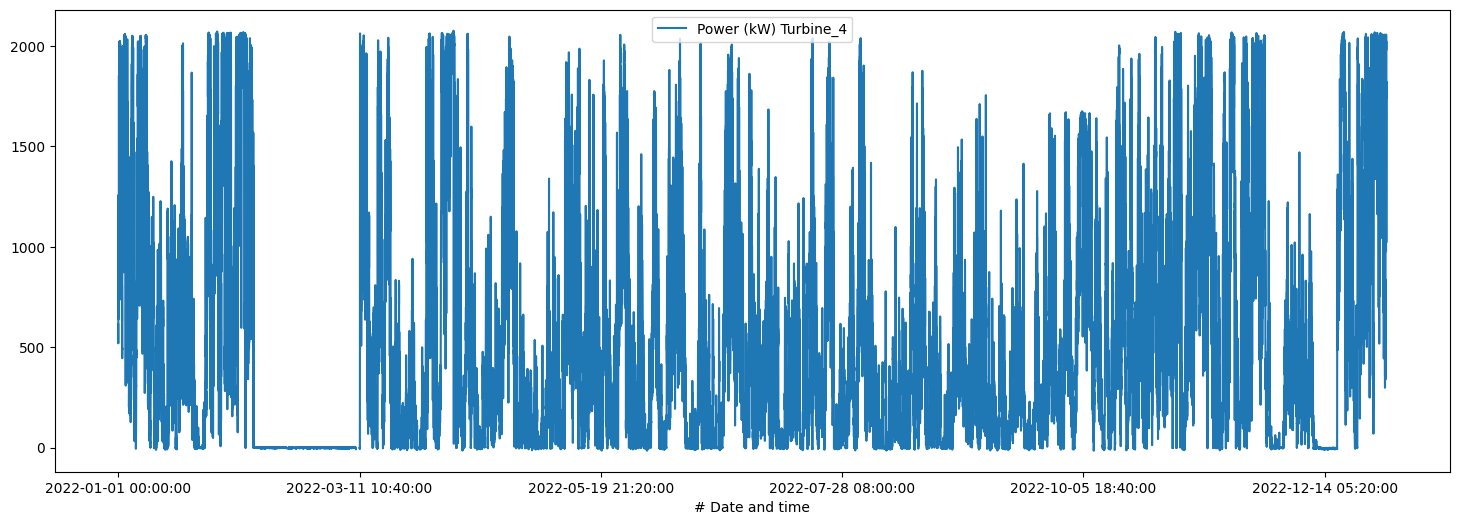

In [54]:
comb_DF_TRB.plot(x='# Date and time', y=tarTurbine, figsize=(18,6))

### Handle Missing Values

In [55]:
def handle_missing_values(df, option):
    """
    Handles missing values in a DataFrame based on the user's choice.

    Parameters:
    - df: The DataFrame containing the data.
    - option: Integer representing the user's choice:
      1 = Replace NaNs with mean
      2 = Replace NaNs with median
      3 = Replace NaNs with linear interpolation

    Returns:
    - df_filled: The DataFrame with missing values handled.
    """
    if option == 1:
        # Replace NaNs with the mean of each column
        df_filled = df.fillna(df.mean())
        print("NaNs have been replaced with the mean of each column.")
    elif option == 2:
        # Replace NaNs with the median of each column
        df_filled = df.fillna(df.median())
        print("NaNs have been replaced with the median of each column.")
    elif option == 3:
        # Replace NaNs with linear interpolation
        df_filled = df.interpolate(method='linear')
        print("NaNs have been replaced using linear interpolation.")
    else:
        raise ValueError("Invalid option. Please choose 1, 2, or 3.")

    return df_filled

option = 3  # User input for handling NaNs
comb_DF_TRB_Clnd = handle_missing_values(comb_DF_TRB, option)
comb_DF_TRB_Clnd.head()

<ipython-input-55-57f9053902b1>:25: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_filled = df.interpolate(method='linear')


NaNs have been replaced using linear interpolation.


# Date and time  Wind speed (m/s) Turbine_1  \
0  2022-01-01 00:00:00                    6.781222   
1  2022-01-01 00:10:00                    6.936052   
2  2022-01-01 00:20:00                    7.294642   
3  2022-01-01 00:30:00                    8.080467   
4  2022-01-01 00:40:00                    7.021328   

   Long Term Wind (m/s) Turbine_1  Wind direction (°) Turbine_1  \
0                            7.21                    185.795348   
1                            7.21                    189.458687   
2                            7.21                    188.648729   
3                            7.21                    188.826550   
4                            7.21                    191.252213   

   Nacelle position (°) Turbine_1  Vane position 1+2 (°) Turbine_1  \
0                      193.731354                        -9.971973   
1                      193.731354                        -6.699598   
2                      193.731354                        -4.183767   
3                      193.731354                        -6.108515   
4                      193.731354                        -1.088158   

   Energy Export (kWh) Turbine_1  Energy Import (kWh) Turbine_1  \
0                          126.0                       0.001887   
1                          116.0                       0.001887   
2                          122.0                       0.001887   
3                          211.0                       0.001887   
4                          136.0                       0.001887   

   Lost Production Total (kWh) Turbine_1  Power (kW) Turbine_1  \
0                              10.818564            630.889598   
1                             -11.235055            809.339449   
2                              -5.118643            893.607333   
3                              26.933563            995.583734   
4                             -26.360199            926.519441   

   Reactive power (kvar) Turbine_1  Front bearing temperature (°C) Turbine_1  \
0                      -190.507286                                 73.852499   
1                      -235.626105                                 73.087500   
2                      -222.190602                                 72.187499   
3                      -240.734678                                 72.530000   
4                      -287.214456                                 73.570000   

   Rear bearing temperature (°C) Turbine_1  \
0                                70.157500   
1                                69.632499   
2                                68.932501   
3                                68.994999   
4                                69.842501   

   Stator temperature 1 (°C) Turbine_1  \
0                            63.590000   
1                            64.622500   
2                            65.120000   
3                            65.405000   
4                            62.717499   

   Nacelle ambient temperature (°C) Turbine_1  \
0                                     12.4775   
1                                     12.4925   
2                                     12.5225   
3                                     12.5700   
4                                     12.5925   

   Nacelle temperature (°C) Turbine_1  Transformer temperature (°C) Turbine_1  \
0                           25.227500                                 54.1125   
1                           23.595000                                 53.2575   
2                           22.265000                                 52.7100   
3                           19.335000                                 53.0875   
4                           18.670001                                 52.9425   

   CPU temperature (°C) Turbine_1  Grid voltage (V) Turbine_1  \
0                          56.375                  400.460632   
1                          57.075                  399.502464   
2                          57.800                  400.339539   
3    

In [56]:
comb_DF_TRB_Clnd.isna().sum()

# Date and time                               0
Wind speed (m/s) Turbine_1                    0
Long Term Wind (m/s) Turbine_1                0
Wind direction (°) Turbine_1                  0
Nacelle position (°) Turbine_1                0
Vane position 1+2 (°) Turbine_1               0
Energy Export (kWh) Turbine_1                 0
Energy Import (kWh) Turbine_1                 0
Lost Production Total (kWh) Turbine_1         0
Power (kW) Turbine_1                          0
Reactive power (kvar) Turbine_1               0
Front bearing temperature (°C) Turbine_1      0
Rear bearing temperature (°C) Turbine_1       0
Stator temperature 1 (°C) Turbine_1           0
Nacelle ambient temperature (°C) Turbine_1    0
Nacelle temperature (°C) Turbine_1            0
Transformer temperature (°C) Turbine_1        0
CPU temperature (°C) Turbine_1                0
Grid voltage (V) Turbine_1                    0
Grid current (A) Turbine_1                    0
Rotor speed (RPM) Turbine_1                   0
Generator RPM (RPM) Turbine_1                 0
Gearbox speed (RPM) Turbine_1                 0
Yaw bearing angle (°) Turbine_1               0
Grid frequency (Hz) Turbine_1                 0
Production Factor Turbine_1                   0
Performance Index Turbine_1                   0
Investment Performance Ratio Turbine_1        0
Operating Performance Ratio Turbine_1         0
Apparent power (kVA) Turbine_1                0
Metal particle count Turbine_1                0
Wind speed (m/s) Turbine_2                    0
Long Term Wind (m/s) Turbine_2                0
Wind direction (°) Turbine_2                  0
Nacelle position (°) Turbine_2                0
Vane position 1+2 (°) Turbine_2               0
Energy Export (kWh) Turbine_2                 0
Energy Import (kWh) Turbine_2                 0
Lost Production Total (kWh) Turbine_2         0
Power (kW) Turbine_2                          0
Reactive power (kvar) Turbine_2               0
Front bearing temperature (°C) Turbine_2      0
Rear bearing temperature (°C) Turbine_2       0
Stator temperature 1 (°C) Turbine_2           0
Nacelle ambient temperature (°C) Turbine_2    0
Nacelle temperature (°C) Turbine_2            0
Transformer temperature (°C) Turbine_2        0
CPU temperature (°C) Turbine_2                0
Grid voltage (V) Turbine_2                    0
Grid current (A) Turbine_2                    0
Rotor speed (RPM) Turbine_2                   0
Generator RPM (RPM) Turbine_2                 0
Gearbox speed (RPM) Turbine_2                 0
Yaw bearing angle (°) Turbine_2               0
Grid frequency (Hz) Turbine_2                 0
Production Factor Turbine_2                   0
Performance Index Turbine_2                   0
Investment Performance Ratio Turbine_2        0
Operating Performance Ratio Turbine_2         0
Apparent power (kVA) Turbine_2                0
Metal particle count Turbine_2                0
Wind speed (m/s) Turbine_3                    0
Long Term Wind (m/s) Turbine_3                0
Wind direction (°) Turbine_3                  0
Nacelle position (°) Turbine_3                0
Vane position 1+2 (°) Turbine_3               0
Energy Export (kWh) Turbine_3                 0
Energy Import (kWh) Turbine_3                 0
Lost Production Total (kWh) Turbine_3         0
Power (kW) Turbine_3                          0
Reactive power (kvar) Turbine_3               0
Front bearing temperature (°C) Turbine_3      0
Rear bearing temperature (°C) Turbine_3       0
Stator temperature 1 (°C) Turbine_3           0
Nacelle ambient temperature (°C) Turbine_3    0
Nacelle temperature (°C) Turbine_3            0
Transformer temperature (°C) Turbine_3        0
CPU temperature (°C) Turbine_3                0
Grid voltage (V) Turbine_3                    0
Grid current (A) Turbine_3                    0
Rotor speed (RPM) Turbine_3                   0
Generator RPM (RPM) Turbine_3                 0
Gearbox speed (RPM) Turbine_3                 0
Yaw bearing angl

### Outlier Detection

In [57]:
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor

def handle_outliers(df, option, replacement_option):
    """
    Detects and handles outliers in a DataFrame based on the user's choice.


    Parameters:
    - df: The DataFrame containing the data.
    - option: Integer representing the user's choice for outlier detection:
    1 = Z-Score method
    2 = Local Outlier Factor (LOF)
    - replacement_option: Integer representing the user's choice for handling outliers:
    1 = Replace outliers with mean
    2 = Replace outliers with median
    3 = Remove outliers


    Returns:
    - df_cleaned: The DataFrame with outliers handled.
    """
    if option == 1:
        # Z-Score method
        z_scores = np.abs(stats.zscore(df))
        outliers = (z_scores > 3)
        print("Outliers detected using Z-Score method.")
    elif option == 2:
        # Local Outlier Factor method
        lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
        outliers = lof.fit_predict(df) == -1
        outliers = np.array([outliers] * df.shape[1]).T # Aligning shape with df
        print("Outliers detected using Local Outlier Factor method.")
    else:
        raise ValueError("Invalid option. Please choose 1 or 2.")


    # Handle outliers
    if replacement_option == 1:
        # Replace outliers with the mean of each column
        df_cleaned = df.mask(outliers, df.mean(), axis=1)
        print("Outliers have been replaced with the mean of each column.")
    elif replacement_option == 2:
        # Replace outliers with the median of each column
        df_cleaned = df.mask(outliers, df.median(), axis=1)
        print("Outliers have been replaced with the median of each column.")
    elif replacement_option == 3:
        # Remove outliers
        df_cleaned = df[~outliers.any(axis=1)]
        print("Outliers have been removed from the dataset.")
    else:
        raise ValueError("Invalid replacement option. Please choose 1, 2, or 3.")


    return df_cleaned


outlier_detection_option = 1 # User input for outlier detection method (1 = Z-Score, 2 = LOF)
outlier_replacement_option = 1 # User input for handling outliers (1 = mean, 2 = median, 3 = remove)


# Handle missing values
# comb_DF_TRB_Clnd = handle_missing_values(comb_DF_TRB, nan_option)

comb_DF_TRB_Clnd.set_index('# Date and time', inplace=True)

# Handle outliers
comb_DF_TRB_Clnd = handle_outliers(comb_DF_TRB_Clnd, outlier_detection_option, outlier_replacement_option)


# Display the cleaned DataFrame
comb_DF_TRB_Clnd = comb_DF_TRB_Clnd.reset_index()
comb_DF_TRB_Clnd.head()

Outliers detected using Z-Score method.
Outliers have been replaced with the mean of each column.


# Date and time  Wind speed (m/s) Turbine_1  \
0  2022-01-01 00:00:00                    6.781222   
1  2022-01-01 00:10:00                    6.936052   
2  2022-01-01 00:20:00                    7.294642   
3  2022-01-01 00:30:00                    8.080467   
4  2022-01-01 00:40:00                    7.021328   

   Long Term Wind (m/s) Turbine_1  Wind direction (°) Turbine_1  \
0                            7.21                    185.795348   
1                            7.21                    189.458687   
2                            7.21                    188.648729   
3                            7.21                    188.826550   
4                            7.21                    191.252213   

   Nacelle position (°) Turbine_1  Vane position 1+2 (°) Turbine_1  \
0                      193.731354                        -9.971973   
1                      193.731354                        -6.699598   
2                      193.731354                        -4.183767   
3                      193.731354                        -6.108515   
4                      193.731354                        -1.088158   

   Energy Export (kWh) Turbine_1  Energy Import (kWh) Turbine_1  \
0                          126.0                       0.001887   
1                          116.0                       0.001887   
2                          122.0                       0.001887   
3                          211.0                       0.001887   
4                          136.0                       0.001887   

   Lost Production Total (kWh) Turbine_1  Power (kW) Turbine_1  \
0                              10.818564            630.889598   
1                             -11.235055            809.339449   
2                              -5.118643            893.607333   
3                              26.933563            995.583734   
4                             -26.360199            926.519441   

   Reactive power (kvar) Turbine_1  Front bearing temperature (°C) Turbine_1  \
0                      -190.507286                                 73.852499   
1                      -235.626105                                 73.087500   
2                      -222.190602                                 72.187499   
3                      -240.734678                                 72.530000   
4                      -287.214456                                 73.570000   

   Rear bearing temperature (°C) Turbine_1  \
0                                70.157500   
1                                69.632499   
2                                68.932501   
3                                68.994999   
4                                69.842501   

   Stator temperature 1 (°C) Turbine_1  \
0                            63.590000   
1                            64.622500   
2                            65.120000   
3                            65.405000   
4                            62.717499   

   Nacelle ambient temperature (°C) Turbine_1  \
0                                     12.4775   
1                                     12.4925   
2                                     12.5225   
3                                     12.5700   
4                                     12.5925   

   Nacelle temperature (°C) Turbine_1  Transformer temperature (°C) Turbine_1  \
0                           25.227500                                 54.1125   
1                           23.595000                                 53.2575   
2                           22.265000                                 52.7100   
3                           19.335000                                 53.0875   
4                           18.670001                                 52.9425   

   CPU temperature (°C) Turbine_1  Grid voltage (V) Turbine_1  \
0                          56.375                  400.460632   
1                          57.075                  399.502464   
2                          57.800                  400.339539   
3    

## Feature Importance

### HEATMAP

In [58]:
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr = comb_DF_TRB_Clnd.select_dtypes('number').corr()
corr.style.background_gradient(cmap, axis=1)\
    .format(precision=3)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_table_styles(magnify())

In [59]:
def get_high_correlation_columns(df, column_name, threshold=0.2):
    """
    Returns columns that have a correlation above or below the specified threshold with the given column.

    Parameters:
    - df: DataFrame containing the data.
    - column_name: The column with which to check correlations.
    - threshold: The correlation threshold (default is 0.2).

    Returns:
    - high_corr_columns: A dictionary with column names and their correlations.
    """
    # Calculate the correlation matrix for numerical columns
    corr_matrix = df.select_dtypes('number').corr()

    # Extract the correlation values for the specified column
    correlations = corr_matrix[column_name]

    # Filter columns with correlations above or below the specified threshold
    high_corr_columns = correlations[(correlations > threshold) | (correlations < -threshold)]

    # Convert to dictionary format
    high_corr_columns_dict = high_corr_columns.to_dict()

    return high_corr_columns_dict

threshold = 0.7
high_corr_columns_dict = get_high_correlation_columns(comb_DF_TRB_Clnd, tarTurbine, threshold=threshold)
high_corr_columns_dict

{'Wind speed (m/s) Turbine_1': 0.7280453629513643,
 'Energy Export (kWh) Turbine_1': 0.716309098536035,
 'Power (kW) Turbine_1': 0.729528776998859,
 'Grid current (A) Turbine_1': 0.7306323029230307,
 'Apparent power (kVA) Turbine_1': 0.7319727691608483,
 'Wind speed (m/s) Turbine_2': 0.7387655147072825,
 'Power (kW) Turbine_2': 0.7088092298552924,
 'Grid current (A) Turbine_2': 0.7072714619008956,
 'Apparent power (kVA) Turbine_2': 0.708502182707672,
 'Power (kW) Turbine_3': 0.7109114058163819,
 'Grid current (A) Turbine_3': 0.7178049337169171,
 'Apparent power (kVA) Turbine_3': 0.7190244582586804,
 'Wind speed (m/s) Turbine_4': 0.7626930708208103,
 'Energy Export (kWh) Turbine_4': 0.9356628546767303,
 'Power (kW) Turbine_4': 1.0,
 'Reactive power (kvar) Turbine_4': -0.9089366240166753,
 'Transformer temperature (°C) Turbine_4': 0.7710802124936269,
 'Grid current (A) Turbine_4': 0.9990578618152948,
 'Rotor speed (RPM) Turbine_4': 0.785251813589605,
 'Generator RPM (RPM) Turbine_4': 0.7

### RANDOM FOREST

In [ ]:
# rfDF = comb_DF_TRB_Clnd.copy()
# rfDF = rfDF.drop(columns=['# Date and time'])  # Drop the 'Date' column

# # Separate features and target
# X = rfDF.drop(columns=[tarTurbine])
# y = rfDF[tarTurbine]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standardize the feature data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [ ]:
# rfDF.isna().sum()

In [ ]:
# print(rfDF.dtypes)

In [ ]:
# # Train a Random Forest classifier
# rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# rf.fit(X_train_scaled, y_train)

# # Get feature importances
# importances = rf.feature_importances_
# feature_names = X.columns
# feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# # Sort the feature importances in descending order
# feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# # Print the feature importances
# print(feature_importances)

In [ ]:
# # Plot the feature importances
# plt.figure(figsize=(15, 15))
# plt.barh(feature_importances['Feature'], feature_importances['Importance'])
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importances from Random Forest Classifier')
# plt.gca().invert_yaxis()
# plt.show()

## Power (KW) Forecasting

### Global Option Selection

In [60]:
highCorrFeatList = list(high_corr_columns_dict.keys())

In [61]:
tsDF = comb_DF_TRB_Clnd[["# Date and time"] + highCorrFeatList].copy()

# Convert 'Date and time' column to datetime format
tsDF['# Date and time'] = pd.to_datetime(tsDF['# Date and time'])

# Get Last Month Data
tsDF = tsDF.tail(4464).reset_index(drop=True)

globalHorizon = 6                      # Change to Increase or Decrease Future Forecast Time Steps in 10 Min Interval
globalWindows = 6                      # Change to Increase or Decrease Cross Validation Folds
globalSeqLength = globalHorizon * 5    # Change to Increase or Decrease Sequence Length/Lookback Value

modelScores = {}

print(tsDF.shape)
tsDF.head()

(4464, 29)


# Date and time  Wind speed (m/s) Turbine_1  \
0 2022-12-01 00:00:00                    1.814794   
1 2022-12-01 00:10:00                    1.905769   
2 2022-12-01 00:20:00                    1.812750   
3 2022-12-01 00:30:00                    2.414213   
4 2022-12-01 00:40:00                    2.707425   

   Energy Export (kWh) Turbine_1  Power (kW) Turbine_1  \
0                       0.067416             -1.172633   
1                       0.067416             -0.788513   
2                       0.067416             -0.562309   
3                       0.067416             -3.082563   
4                       0.067416             -2.141469   

   Grid current (A) Turbine_1  Apparent power (kVA) Turbine_1  \
0                    5.848833                        1.152894   
1                    4.966583                        0.818389   
2                    4.395583                        0.563910   
3                    8.876491                        3.064424   
4                    7.517778                        2.173479   

   Wind speed (m/s) Turbine_2  Power (kW) Turbine_2  \
0                    1.807613             -1.818702   
1                    1.856062             -2.220961   
2                    1.959694             -1.176901   
3                    2.469431             -2.479175   
4                    2.767350             -2.401817   

   Grid current (A) Turbine_2  Apparent power (kVA) Turbine_2  \
0                    5.183917                        1.858714   
1                    5.768333                        2.222561   
2                    4.657250                        1.160896   
3                    6.387833                        2.481309   
4                    6.422833                        2.404485   

   Power (kW) Turbine_3  Grid current (A) Turbine_3  \
0             -3.319437                    9.020667   
1             -2.881434                    9.206417   
2             -4.198112                   10.160083   
3             -3.704625                    9.904583   
4             -4.205581                   10.311083   

   Apparent power (kVA) Turbine_3  Wind speed (m/s) Turbine_4  \
0                        3.333842                    1.541812   
1                        2.895838                    2.245819   
2                        4.199712                    2.247000   
3                        3.717428                    2.504775   
4                        4.235990                    2.725050   

   Energy Export (kWh) Turbine_4  Power (kW) Turbine_4  \
0                       0.148936             -0.456143   
1                       0.148936             -1.700265   
2                       0.148936             -1.174234   
3                       0.148936             -1.946742   
4                       0.148936             -1.985154   

   Reactive power (kvar) Turbine_4  Transformer temperature (°C) Turbine_4  \
0                              0.0                               30.670001   
1                              0.0                               30.657501   
2                              0.0                               30.687501   
3                              0.0                               30.697501   
4                              0.0                               30.670001   

   Grid current (A) Turbine_4  Rotor speed (RPM) Turbine_4  \
0                    4.229417                     0.232634   
1                    6.244000                     0.528591   
2                    5.647250                     0.567440   
3                    6.909750                     0.621873   
4                    6.745417                     0.725550   

   Generator RPM (RPM) Turbine_4  Gearbox speed (RPM) Turbine_4  \
0                      30.974228                      35.205035   
1                      62.977500                      64.830192   
2                      66.001198                      68.366832   
3                      72.110471            

#### Metric Score Calculation Helper Function

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

def getScore(y_test, y_pred):
    # Calculate evaluation metrics
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2Score = r2_score(y_test, y_pred)

    # Display the results
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"R2_Score: {r2Score}")

    return rmse, mae, mape, r2Score

### Patch-TST

In [63]:
def frcstPatchTST(fDF, targetFeature):
    horizon = globalHorizon
    wind_turbine_df = fDF.copy()
    wind_turbine_df['# Date and time'] = pd.to_datetime(wind_turbine_df['# Date and time'])


    # Prepare data
    wind_turbine_df = wind_turbine_df.rename(columns={'# Date and time': 'ds', tarTurbine: 'y'})
    wind_turbine_df['unique_id'] = 'turbine_group'  # Treating all turbines as one series

    # Split data into train and test sets
    split_point = len(wind_turbine_df) - globalHorizon  # Last Horizon points for testing
    Y_train_df = wind_turbine_df.iloc[:split_point]
    Y_test_df = wind_turbine_df.iloc[split_point:]

    # Define the model
    model = PatchTST(h=horizon,  # Forecast horizon
                    input_size=globalSeqLength,
                    patch_len=16,
                    stride=8,
                    revin=True,
                    hidden_size=64,
                    n_heads=4,
                    scaler_type='robust',
                    loss=MAE(),
                    learning_rate=1e-3,
                    max_steps=500,
                    )

    # Create NeuralForecast object
    nf = NeuralForecast(models=[model], freq='10T')

    # Perform cross-validation
    cv_results = nf.cross_validation(
        df=wind_turbine_df,
        n_windows=globalWindows,
        step_size=horizon
    )


    # Fit the model on the entire dataset for Future Forecast
    nf.fit(df=wind_turbine_df)

    # Generate forecasts for the next specified number of horizon time steps
    future_dates = pd.date_range(start=wind_turbine_df['ds'].max(), periods=globalHorizon+1, freq='10T')[1:]
    future_df = pd.DataFrame({
        'unique_id': ['turbine_group'] * horizon,
        'ds': future_dates
    })

    forecasts = nf.predict(futr_df=future_df)

    print(f"Forecasts for the next {horizon} time steps:")
    print(forecasts)

    return cv_results, forecasts


insampleResDF, forecastDF = frcstPatchTST(tsDF, tarTurbine)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 152 K  | train
-----------------------------------------------------------
152 K     Trainable params
3         Non-trainable params
152 K     Total params
0.610     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 152 K  | train
-----------------------------------------------------------
152 K     Trainable params
3         Non-tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Forecasts for the next 6 time steps:
                               ds     PatchTST
unique_id                                     
turbine_group 2023-01-01 00:00:00  1744.601562
turbine_group 2023-01-01 00:10:00  1702.620361
turbine_group 2023-01-01 00:20:00  1761.559204
turbine_group 2023-01-01 00:30:00  1772.298828
turbine_group 2023-01-01 00:40:00  1718.960938
turbine_group 2023-01-01 00:50:00  1643.318359


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


#### Get Metrics Score For Each Window

In [64]:
# Initialize lists to hold the results
rmse_scores = []
mae_scores = []
mape_scores = []
r2Score_scores = []

# Calculate and print metrics for each window
for window in insampleResDF['cutoff'].unique():
    window_data = insampleResDF[insampleResDF['cutoff'] == window]
    y_true = window_data['y']
    y_pred = window_data['PatchTST']

    print(f"Window: {window}")
    rmse, mae, mape, r2Score = getScore(y_true, y_pred)
    print("---\n")

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)
    r2Score_scores.append(r2Score)


# Display the average scores across all folds
print(f"\n\nAverage RMSE: {np.mean(rmse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average MAPE: {np.mean(mape_scores)}")
print(f"Average R2-Score: {np.mean(r2Score_scores)}")

modelScores['PatchTST'] = {"RMSE": rmse_scores, "MAE": mae_scores, "MAPE": mape_scores, "R2": r2Score_scores}

Window: 2022-12-31 17:50:00
RMSE: 446.1369121960375
MAE: 433.88195597330827
MAPE: 0.30565786932049593
R2_Score: -20.070161930433276
---

Window: 2022-12-31 18:50:00
RMSE: 445.6270109740714
MAE: 424.9798014322903
MAPE: 0.3137805837754996
R2_Score: -5.748640793031926
---

Window: 2022-12-31 19:50:00
RMSE: 425.8387109098272
MAE: 315.0326144837486
MAPE: 0.2846520503038447
R2_Score: -2.7261669840012868
---

Window: 2022-12-31 20:50:00
RMSE: 663.7908087777505
MAE: 578.4050394694024
MAPE: 0.30091266133345135
R2_Score: -1.9611148665421703
---

Window: 2022-12-31 21:50:00
RMSE: 427.21303439814153
MAE: 274.5900027358744
MAPE: 0.22812696206807062
R2_Score: -0.2861062825539311
---

Window: 2022-12-31 22:50:00
RMSE: 160.09664253947452
MAE: 135.90343170166082
MAPE: 0.08266583903500266
R2_Score: 0.6323518951374139
---



Average RMSE: 428.1171866325505
Average MAE: 360.4654742993808
Average MAPE: 0.25263266097272746
Average R2-Score: -5.026639826904197


#### Visualize Actual vs Pred for Specified Window/Fold

In [65]:
def plot_window_forecast(cv_results, window, model_name='PatchTST'):
    # Filter data for the specific window
    window_data = cv_results[cv_results['cutoff'] == window]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(window_data['ds'], window_data['y'], label='Actual', marker='o', linestyle='--')
    plt.plot(window_data['ds'], window_data[model_name], label='Predicted', marker='x', linestyle='-')

    # Customize the plot
    plt.title(f'Actual vs Predicted for Window: {window}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_window_forecast(insampleResDF, '2022-12-31 22:50:00')

###CNN-LSTM

In [83]:
# Set seeds for reproducibility
seed_value = 42  # Can choose any seed value
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

In [84]:
# Splitting the data into features and target
X = tsDF.drop(columns=[tarTurbine, '# Date and time'])
y = tsDF[tarTurbine]

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Set the lookback period for sequence creation
lookback = globalSeqLength
forecast_horizon = globalHorizon

def create_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback - forecast_horizon + 1):
        X_seq.append(X[i:i + lookback])
        y_seq.append(y[i + lookback:i + lookback + forecast_horizon])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y, lookback)

# Define cross-validation with Specified number of globalWindows folds
tscv = TimeSeriesSplit(n_splits=globalWindows)

winTestResCNNLSTM = {}

# Initialize lists to hold the results
rmse_scores_cnnlstm = []
mae_scores_cnnlstm = []
mape_scores_cnnlstm = []
r2Score_scores_cnnlstm = []

for fold, (train_index, val_index) in enumerate(tscv.split(X_seq)):
    print(f"Training fold {fold+1}...")

    # Split the data into training and validation sets
    X_train, X_val = X_seq[train_index], X_seq[val_index]
    y_train, y_val = y_seq[train_index], y_seq[val_index]

    # Define the CNN-LSTM model
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(lookback, X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(LSTM(100, activation='relu', return_sequences=True, kernel_regularizer='l2'))
    model.add(Dropout(0.3))
    model.add(LSTM(100, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(forecast_horizon))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'best_model_fold_{fold+1}.keras', monitor='val_loss', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    ]

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks, verbose=1)

    # Predict on the validation set
    y_pred = model.predict(X_val)

    # Calculate metrics for this fold
    y_val_flat_cnnlstm = y_val.flatten()
    y_pred_flat_cnnlstm = y_pred.flatten()

    # Last Actual & Predicted Forecast Horizon Values from the test set for the Window
    y_val_flat_cnnlstm = y_val_flat_cnnlstm[-forecast_horizon:]
    y_pred_flat_cnnlstm = y_pred_flat_cnnlstm[-forecast_horizon:]

    winTestResCNNLSTM[fold+1] = y_val_flat_cnnlstm, y_pred_flat_cnnlstm

    rmse, mae, mape, r2Score = getScore(y_val_flat_cnnlstm, y_pred_flat_cnnlstm)

    rmse_scores_cnnlstm.append(rmse)
    mae_scores_cnnlstm.append(mae)
    mape_scores_cnnlstm.append(mape)
    r2Score_scores_cnnlstm.append(r2Score)

    # break

Training fold 1...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - loss: 149608.6719 - val_loss: 119636.1172 - learning_rate: 0.0010
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 106241.8672 - val_loss: 60356.5312 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 54124.7969 - val_loss: 64034.0898 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 46237.0781 - val_loss: 55098.9062 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 43281.0391 - val_loss: 53960.0703 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 43622.4922 - val_loss: 56452.0195 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 43135.9180 - val_loss: 56159.8867 - learning_rate: 0.0010
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 42573.1055 - val_loss: 54383.8984 - learning_rate: 0.0010
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 4

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 122975.9062 - val_loss: 29649.7051 - learning_rate: 0.0010
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 55189.1602 - val_loss: 22109.1113 - learning_rate: 0.0010
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 51250.3086 - val_loss: 24570.8750 - learning_rate: 0.0010
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 50493.6289 - val_loss: 23722.6992 - learning_rate: 0.0010
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 51131.6836 - val_loss: 22052.5586 - learning_rate: 0.0010
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 51353.9727 - val_loss: 23495.5684 - learning_rate: 0.0010
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 46727.3828 - val_loss: 21487.3047 - learning_rate: 0.0010
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 48138.3672 - val_loss: 18413.0898 - learning_rate: 0.0010
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 44

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 93593.7500 - val_loss: 130925.2656 - learning_rate: 0.0010
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 36529.6055 - val_loss: 139609.1719 - learning_rate: 0.0010
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 35770.5391 - val_loss: 159749.5625 - learning_rate: 0.0010
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 32858.0391 - val_loss: 151318.1719 - learning_rate: 0.0010
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 32168.4883 - val_loss: 135357.7031 - learning_rate: 0.0010
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 29889.7129 - val_loss: 149745.9375 - learning_rate: 0.0010
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 30783.0000 - val_loss: 113291.6094 - learning_rate: 5.0000e-04
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 26763.5156 - val_loss: 121007.0156 - learning_rate: 5.0000e-04
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 118244.4297 - val_loss: 140130.3594 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 57849.1445 - val_loss: 204895.0156 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 50628.7500 - val_loss: 131515.0781 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 46187.1289 - val_loss: 238705.3438 - learning_rate: 0.0010
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 45023.0273 - val_loss: 190559.5781 - learning_rate: 0.0010
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 41328.9688 - val_loss: 112807.8750 - learning_rate: 0.0010
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 40488.0781 - val_loss: 112562.2188 - learning_rate: 0.0010
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 43182.4648 - val_loss: 124070.3672 - learning_rate: 0.0010
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - lo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 258122.2969 - val_loss: 307565.4062 - learning_rate: 0.0010
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 101395.2188 - val_loss: 307752.0625 - learning_rate: 0.0010
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 80494.7734 - val_loss: 292393.9062 - learning_rate: 0.0010
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 90695.1250 - val_loss: 292277.3750 - learning_rate: 0.0010
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 71464.6250 - val_loss: 308767.4375 - learning_rate: 0.0010
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 67644.5234 - val_loss: 322090.0625 - learning_rate: 0.0010
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 68981.3438 - val_loss: 269398.2812 - learning_rate: 0.0010
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 63963.0508 - val_loss: 249061.7969 - learning_rate: 0.0010
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 317288.0625 - val_loss: 491058.6250 - learning_rate: 0.0010
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 136681.4375 - val_loss: 379351.4688 - learning_rate: 0.0010
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 116348.0469 - val_loss: 614651.0625 - learning_rate: 0.0010
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 107910.3047 - val_loss: 339737.9375 - learning_rate: 0.0010
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 100462.7344 - val_loss: 291071.7500 - learning_rate: 0.0010
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 89758.5547 - val_loss: 252848.2500 - learning_rate: 0.0010
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 85117.5078 - val_loss: 211104.0000 - learning_rate: 0.0010
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 84546.5234 - val_loss: 227346.8281 - learning_rate: 0.0010
Epoch 9/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 73m

In [85]:
# Display the average scores across all folds
print(f"\n\nAverage RMSE: {np.mean(rmse_scores_cnnlstm)}")
print(f"Average MAE: {np.mean(mae_scores_cnnlstm)}")
print(f"Average MAPE: {np.mean(mape_scores_cnnlstm)}")
print(f"Average R2-Score: {np.mean(r2Score_scores_cnnlstm)}")

modelScores['CNN-LSTM'] = {"RMSE": rmse_scores_cnnlstm, "MAE": mae_scores_cnnlstm, "MAPE": mape_scores_cnnlstm, "R2": r2Score_scores_cnnlstm}



Average RMSE: 263.24011362935045
Average MAE: 241.1672710658735
Average MAPE: 0.9988136482866338
Average R2-Score: -55.2914531785442


### CNN-GRU

In [69]:
from keras.layers import GRU, Input

In [70]:
winTestResCNNGRU = {}

# Initialize lists to hold the results
rmse_scores_cnngru = []
mae_scores_cnngru = []
mape_scores_cnngru = []
r2Score_scores_cnngru = []

for fold, (train_index, val_index) in enumerate(tscv.split(X_seq)):
    print(f"Training fold {fold+1}...")

    # Split the data into training and validation sets
    X_train, X_val = X_seq[train_index], X_seq[val_index]
    y_train, y_val = y_seq[train_index], y_seq[val_index]

    # Define the CNN-GRU model
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(lookback, X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(GRU(100, activation='relu', return_sequences=True, kernel_regularizer='l2'))
    model.add(Dropout(0.3))
    model.add(GRU(100, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(forecast_horizon))

    # Compile the model
    optimizer1 = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer1, loss='mean_squared_error')

    # Define callbacks
    callbacks1 = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'best_model_fold_{fold+1}.keras', monitor='val_loss', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    ]

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks1, verbose=1)

    # Predict on the validation set
    y_pred = model.predict(X_val)

    # Calculate metrics for this fold
    y_val_flat_cnngru = y_val.flatten()
    y_pred_flat_cnngru = y_pred.flatten()

    # Last Actual & Predicted Forecast Horizon Values from the test set for the Window
    y_val_flat_cnngru = y_val_flat_cnngru[-forecast_horizon:]
    y_pred_flat_cnngru = y_pred_flat_cnngru[-forecast_horizon:]

    winTestResCNNGRU[fold+1] = y_val_flat_cnngru, y_pred_flat_cnngru

    rmse, mae, mape, r2Score = getScore(y_val_flat_cnngru, y_pred_flat_cnngru)

    rmse_scores_cnngru.append(rmse)
    mae_scores_cnngru.append(mae)
    mape_scores_cnngru.append(mape)
    r2Score_scores_cnngru.append(r2Score)

    # break

Training fold 1...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 150979.4219 - val_loss: 115818.4688 - learning_rate: 0.0010
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 75289.9375 - val_loss: 66698.5234 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 48435.1875 - val_loss: 50593.3516 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 40035.6172 - val_loss: 49551.2266 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 38988.0508 - val_loss: 51529.5195 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 39087.1016 - val_loss: 47163.5742 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 36326.5664 - val_loss: 47299.0117 - learning_rate: 0.0010
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 37600.7422 - val_loss: 46035.6719 - learning_rate: 0.0010
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 37386.5625 - v

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 138118.2344 - val_loss: 26390.1504 - learning_rate: 0.0010
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 53186.4375 - val_loss: 13877.7393 - learning_rate: 0.0010
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 44502.2578 - val_loss: 14227.3447 - learning_rate: 0.0010
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 46521.6055 - val_loss: 14560.3828 - learning_rate: 0.0010
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 46055.1484 - val_loss: 10042.7832 - learning_rate: 0.0010
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 41514.0469 - val_loss: 11926.0605 - learning_rate: 0.0010
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 42445.3633 - val_loss: 9125.3955 - learning_rate: 0.0010
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 38661.0156 - val_loss: 8447.1396 - learning_rate: 0.0010
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 38448.5977 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 86798.5781 - val_loss: 161965.2500 - learning_rate: 0.0010
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 32581.5020 - val_loss: 127229.2891 - learning_rate: 0.0010
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 29001.9238 - val_loss: 103124.0234 - learning_rate: 0.0010
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 27202.6836 - val_loss: 102902.0469 - learning_rate: 0.0010
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 24504.0293 - val_loss: 91536.0156 - learning_rate: 0.0010
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 25475.8750 - val_loss: 92677.0000 - learning_rate: 0.0010
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 23468.9395 - val_loss: 84000.0234 - learning_rate: 0.0010
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 23354.3281 - val_loss: 85992.9531 - learning_rate: 0.0010
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 130321.0703 - val_loss: 111591.0625 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 51061.6797 - val_loss: 258718.4844 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 44684.3438 - val_loss: 133579.6250 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 35966.5352 - val_loss: 108252.4141 - learning_rate: 0.0010
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 32034.6641 - val_loss: 125238.7734 - learning_rate: 0.0010
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 30064.2949 - val_loss: 109433.5938 - learning_rate: 0.0010
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 28751.8262 - val_loss: 159308.8281 - learning_rate: 0.0010
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 27979.2949 - val_loss: 135206.9688 - learning_rate: 0.0010
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 299628.9062 - val_loss: 259304.7656 - learning_rate: 0.0010
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 74826.3672 - val_loss: 242471.2969 - learning_rate: 0.0010
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 68994.4844 - val_loss: 236136.3594 - learning_rate: 0.0010
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 57678.8242 - val_loss: 204662.4375 - learning_rate: 0.0010
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 60055.9922 - val_loss: 190454.2500 - learning_rate: 0.0010
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 49759.1445 - val_loss: 178877.0000 - learning_rate: 0.0010
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 48601.8789 - val_loss: 178806.3906 - learning_rate: 0.0010
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 48401.1445 - val_loss: 161562.2969 - learning_rate: 0.0010
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 45427.2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 365224.2188 - val_loss: 301930.7812 - learning_rate: 0.0010
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - loss: 114394.5625 - val_loss: 243797.0625 - learning_rate: 0.0010
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 97211.6875 - val_loss: 205067.4375 - learning_rate: 0.0010
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 84557.6719 - val_loss: 180852.0625 - learning_rate: 0.0010
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 81697.3203 - val_loss: 186320.0938 - learning_rate: 0.0010
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 69916.5938 - val_loss: 201898.9062 - learning_rate: 0.0010
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 72042.8672 - val_loss: 146030.5000 - learning_rate: 0.0010
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 67057.2812 - val_loss: 138289.5000 - learning_rate: 0.0010
Epoch 9/10
119/119 ━━━━━━━━━━━━━━

In [96]:
# Display the average scores across all folds
print(f"\n\nAverage RMSE: {np.mean(rmse_scores_cnngru)}")
print(f"Average MAE: {np.mean(mae_scores_cnngru)}")
print(f"Average MAPE: {np.mean(mape_scores_cnngru)}")
print(f"Average R2-Score: {np.mean(r2Score_scores_cnngru)}")

modelScores['CNN-GRU'] = {"RMSE": rmse_scores_cnngru, "MAE": mae_scores_cnngru, "MAPE": mape_scores_cnngru, "R2": r2Score_scores_cnngru}



Average RMSE: 238.27217564400928
Average MAE: 196.58340642898852
Average MAPE: 0.6561074763752021
Average R2-Score: -11.646764065282241


###LSTM

In [ ]:
winTestResLSTM = {}

# Initialize lists to hold the results
rmse_scores_lstm = []
mae_scores_lstm = []
mape_scores_lstm = []
r2Score_scores_lstm = []

for fold, (train_index, val_index) in enumerate(tscv.split(X_seq)):
    print(f"Training fold {fold+1}...")

    # Split the data into training and validation sets
    X_train, X_val = X_seq[train_index], X_seq[val_index]
    y_train, y_val = y_seq[train_index], y_seq[val_index]

    # Define the baseline LSTM model
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, kernel_regularizer='l2'))
    model.add(Dropout(0.3))
    model.add(LSTM(100, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(forecast_horizon))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'best_model_fold_{fold+1}.keras', monitor='val_loss', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    ]

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks, verbose=1)

    # Predict on the validation set
    y_pred = model.predict(X_val)

    # Calculate metrics for this fold
    y_val_flat_lstm = y_val.flatten()
    y_pred_flat_lstm = y_pred.flatten()

    # Last Actual & Predicted Forecast Horizon Values from the test set for the Window
    y_val_flat_lstm = y_val_flat_lstm[-forecast_horizon:]
    y_pred_flat_lstm = y_pred_flat_lstm[-forecast_horizon:]

    winTestResLSTM[fold+1] = y_val_flat_lstm, y_pred_flat_lstm

    rmse, mae, mape, r2Score = getScore(y_val_flat_lstm, y_pred_flat_lstm)

    rmse_scores_lstm.append(rmse)
    mae_scores_lstm.append(mae)
    mape_scores_lstm.append(mape)
    r2Score_scores_lstm.append(r2Score)

    # break

Training fold 1...
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - loss: 156740.2656 - val_loss: 166868.7656 - learning_rate: 0.0010
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 149195.4531 - val_loss: 170895.1719 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 145119.0469 - val_loss: 161733.7812 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 105142.5391 - val_loss: 65003.5195 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 48282.0625 - val_loss: 53665.3477 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 47853.5430 - val_loss: 60778.5898 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 46891.6445 - val_loss: 57581.6836 - learning_rate: 0.0010
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 45638.5820 - val_loss: 56786.5938 - learning_rate: 0.0010
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━

In [ ]:
# Display the average scores across all folds
print(f"\n\nAverage RMSE: {np.mean(rmse_scores_lstm)}")
print(f"Average MAE: {np.mean(mae_scores_lstm)}")
print(f"Average MAPE: {np.mean(mape_scores_lstm)}")
print(f"Average R2-Score: {np.mean(r2Score_scores_lstm)}")

modelScores['LSTM'] = {"RMSE": rmse_scores_lstm, "MAE": mae_scores_lstm, "MAPE": mape_scores_lstm, "R2": r2Score_scores_lstm}



Average RMSE: 232.27886551835613
Average MAE: 203.22434159235422
Average MAPE: 3.716043321969528
Average R2-Score: -1558.3083447028273


###GRU

In [ ]:
winTestResGRU = {}

# Initialize lists to hold the results
rmse_scores_gru = []
mae_scores_gru = []
mape_scores_gru = []
r2Score_scores_gru = []

for fold, (train_index, val_index) in enumerate(tscv.split(X_seq)):
    print(f"Training fold {fold+1}...")

    # Split the data into training and validation sets
    X_train, X_val = X_seq[train_index], X_seq[val_index]
    y_train, y_val = y_seq[train_index], y_seq[val_index]

    # Define the baseline GRU model
    model = Sequential()
    model.add(GRU(100, activation='relu', return_sequences=True, kernel_regularizer='l2'))
    model.add(Dropout(0.3))
    model.add(GRU(100, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(forecast_horizon))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'best_model_fold_{fold+1}.keras', monitor='val_loss', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    ]

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks, verbose=1)

    # Predict on the validation set
    y_pred = model.predict(X_val)

    # Calculate metrics for this fold
    y_val_flat_gru = y_val.flatten()
    y_pred_flat_gru = y_pred.flatten()

    # Last Actual & Predicted Forecast Horizon Values from the test set for the Window
    y_val_flat_gru = y_val_flat_gru[-forecast_horizon:]
    y_pred_flat_gru = y_pred_flat_gru[-forecast_horizon:]

    winTestResGRU[fold+1] = y_val_flat_gru, y_pred_flat_gru

    rmse, mae, mape, r2Score = getScore(y_val_flat_gru, y_pred_flat_gru)

    rmse_scores_gru.append(rmse)
    mae_scores_gru.append(mae)
    mape_scores_gru.append(mape)
    r2Score_scores_gru.append(r2Score)

    # break

Training fold 1...
Epoch 1/10


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x78f2ea5f1b40>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Display the average scores across all folds
print(f"\n\nAverage RMSE: {np.mean(rmse_scores_gru)}")
print(f"Average MAE: {np.mean(mae_scores_gru)}")
print(f"Average MAPE: {np.mean(mape_scores_gru)}")
print(f"Average R2-Score: {np.mean(r2Score_scores_gru)}")

modelScores['GRU'] = {"RMSE": rmse_scores_gru, "MAE": mae_scores_gru, "MAPE": mape_scores_gru, "R2": r2Score_scores_gru}

#### Visualizse Actual vs Pred for Specified Window/Fold - CNN-LSTM

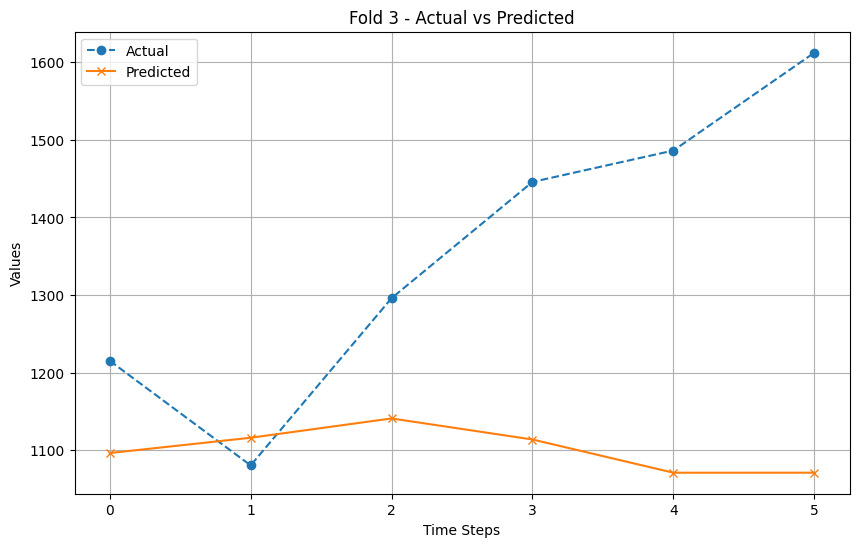

In [86]:
def plot_actual_vs_pred(fold_data, fold_number):
    """
    Plots the actual vs predicted values for a specified fold number.

    Parameters:
    - fold_data: A dictionary where each key is a fold number, and each value is a tuple containing
                 the actual values (array) and the predicted values (array).
    - fold_number: The fold number to plot.
    """
    # Check if the fold number exists in the data
    if fold_number not in fold_data:
        print(f"Fold {fold_number} not found in the data.")
        return

    # Extract actual and predicted values
    actual_values, predicted_values = fold_data[fold_number]

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(actual_values, label='Actual', marker='o', linestyle='--')
    plt.plot(predicted_values, label='Predicted', marker='x', linestyle='-')
    plt.title(f'Fold {fold_number} - Actual vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_actual_vs_pred(winTestResCNNLSTM, 3)

#### Visualizse Actual vs Pred for Specified Window/Fold - CNN-GRU

In [72]:
def plot_actual_vs_pred1(fold_data, fold_number):
    """
    Plots the actual vs predicted values for a specified fold number.

    Parameters:
    - fold_data: A dictionary where each key is a fold number, and each value is a tuple containing
                 the actual values (array) and the predicted values (array).
    - fold_number: The fold number to plot.
    """
    # Check if the fold number exists in the data
    if fold_number not in fold_data:
        print(f"Fold {fold_number} not found in the data.")
        return

    # Extract actual and predicted values
    actual_values, predicted_values = fold_data[fold_number]

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(actual_values, label='Actual', marker='o', linestyle='--')
    plt.plot(predicted_values, label='Predicted', marker='x', linestyle='-')
    plt.title(f'Fold {fold_number} - Actual vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_actual_vs_pred1(winTestResCNNGRU, 5)

#### Visualizse Actual vs Pred for Specified Window/Fold - LSTM

In [ ]:
def plot_actual_vs_pred(fold_data, fold_number):
    """
    Plots the actual vs predicted values for a specified fold number.

    Parameters:
    - fold_data: A dictionary where each key is a fold number, and each value is a tuple containing
                 the actual values (array) and the predicted values (array).
    - fold_number: The fold number to plot.
    """
    # Check if the fold number exists in the data
    if fold_number not in fold_data:
        print(f"Fold {fold_number} not found in the data.")
        return

    # Extract actual and predicted values
    actual_values, predicted_values = fold_data[fold_number]

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(actual_values, label='Actual', marker='o', linestyle='--')
    plt.plot(predicted_values, label='Predicted', marker='x', linestyle='-')
    plt.title(f'Fold {fold_number} - Actual vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_actual_vs_pred(winTestResLSTM, 3)

#### Visualizse Actual vs Pred for Specified Window/Fold - GRU

In [ ]:
def plot_actual_vs_pred(fold_data, fold_number):
    """
    Plots the actual vs predicted values for a specified fold number.

    Parameters:
    - fold_data: A dictionary where each key is a fold number, and each value is a tuple containing
                 the actual values (array) and the predicted values (array).
    - fold_number: The fold number to plot.
    """
    # Check if the fold number exists in the data
    if fold_number not in fold_data:
        print(f"Fold {fold_number} not found in the data.")
        return

    # Extract actual and predicted values
    actual_values, predicted_values = fold_data[fold_number]

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(actual_values, label='Actual', marker='o', linestyle='--')
    plt.plot(predicted_values, label='Predicted', marker='x', linestyle='-')
    plt.title(f'Fold {fold_number} - Actual vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_actual_vs_pred(winTestResGRU, 5)

#### Generate Future Forecast for CNN-LSTM

In [87]:
# Take the last 'lookback' rows from the dataset
X_last =  tsDF.drop(columns=[tarTurbine, '# Date and time']).tail(lookback).values

# Scale the features
X_last_scaled = scaler.transform(X_last)

# Reshape to match the input shape expected by the model (1 sample, lookback, number of features)
X_last_scaled = X_last_scaled.reshape(1, lookback, X_last_scaled.shape[1])

# Load Best Model
bestCNNLSTMModel = load_model("best_model_fold_3.keras")

# Use the trained model to predict the next time steps
y_future_pred = bestCNNLSTMModel.predict(X_last_scaled)

forecastDF['CNN-LSTM'] = y_future_pred[0]

# Display the predicted values for the next time steps
print("Predicted values for the next 6 time steps:")
print(y_future_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
Predicted values for the next 6 time steps:
[[1046.0656 1064.6917 1086.0145 1062.4075 1020.9174 1019.7757]]


#### Generate Future Forecast for CNN-GRU

In [73]:
# Take the last 'lookback' rows from the dataset
X_last =  tsDF.drop(columns=[tarTurbine, '# Date and time']).tail(lookback).values

# Scale the features
X_last_scaled = scaler.transform(X_last)

# Reshape to match the input shape expected by the model (1 sample, lookback, number of features)
X_last_scaled = X_last_scaled.reshape(1, lookback, X_last_scaled.shape[1])

# Load Best Model
bestCNNGRUModel = load_model("best_model_fold_5.keras")

# Use the trained model to predict the next time steps
y_future_pred_cnngru = bestCNNGRUModel.predict(X_last_scaled)

forecastDF['CNN-GRU'] = y_future_pred_cnngru[0]

# Display the predicted values for the next time steps
print("Predicted values for the next 6 time steps:")
print(y_future_pred_cnngru)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
Predicted values for the next 6 time steps:
[[1615.7363 1606.9562 1596.2292 1602.356  1621.3262 1583.809 ]]


#### Generate Future Forecast for LSTM

In [ ]:
# Take the last 'lookback' rows from the dataset
X_last =  tsDF.drop(columns=[tarTurbine, '# Date and time']).tail(lookback).values

# Scale the features
X_last_scaled = scaler.transform(X_last)

# Reshape to match the input shape expected by the model (1 sample, lookback, number of features)
X_last_scaled = X_last_scaled.reshape(1, lookback, X_last_scaled.shape[1])

# Load Best Model
bestLSTMModel = load_model("best_model_fold_3.keras")

# Use the trained model to predict the next time steps
y_future_pred_lstm = bestLSTMModel.predict(X_last_scaled)

forecastDF['LSTM'] = y_future_pred_lstm[0]

# Display the predicted values for the next time steps
print("Predicted values for the next 6 time steps:")
print(y_future_pred_lstm)

#### Generate Future Forecast for GRU

In [ ]:
# Take the last 'lookback' rows from the dataset
X_last =  tsDF.drop(columns=[tarTurbine, '# Date and time']).tail(lookback).values

# Scale the features
X_last_scaled = scaler.transform(X_last)

# Reshape to match the input shape expected by the model (1 sample, lookback, number of features)
X_last_scaled = X_last_scaled.reshape(1, lookback, X_last_scaled.shape[1])

# Load Best Model
bestGRUModel = load_model("best_model_fold_5.keras")

# Use the trained model to predict the next time steps
y_future_pred_gru = bestGRUModel.predict(X_last_scaled)

forecastDF['GRU'] = y_future_pred_gru[0]

# Display the predicted values for the next time steps
print("Predicted values for the next 6 time steps:")
print(y_future_pred_gru)

## InSample & Out of Sample Visualization

### InSample Score Visualization

In [88]:
modelScores

{'PatchTST': {'RMSE': [446.1369121960375,
   445.6270109740714,
   425.8387109098272,
   663.7908087777505,
   427.21303439814153,
   160.09664253947452],
  'MAE': [433.88195597330827,
   424.9798014322903,
   315.0326144837486,
   578.4050394694024,
   274.5900027358744,
   135.90343170166082],
  'MAPE': [0.30565786932049593,
   0.3137805837754996,
   0.2846520503038447,
   0.30091266133345135,
   0.22812696206807062,
   0.08266583903500266],
  'R2': [-20.070161930433276,
   -5.748640793031926,
   -2.7261669840012868,
   -1.9611148665421703,
   -0.2861062825539311,
   0.6323518951374139]},
 'CNN-LSTM': {'RMSE': [158.8315274496315,
   12.268278262827003,
   320.3272567174154,
   87.62644494430323,
   720.6904808589973,
   279.69669354292813],
  'MAE': [127.21130695343017,
   12.173444700868506,
   266.4802059775909,
   80.21874024943826,
   690.2658294945445,
   270.6540990193688],
  'MAPE': [0.5967904132634206,
   3.7194865224009503,
   0.1826252891142417,
   0.9438264489284451,
   0.

In [89]:
def plot_model_scores_grouped_bar(modelScores, metric):
    """
    Plots the specified metric for both models across all folds using a grouped bar chart.

    Parameters:
    - modelScores: Dictionary containing model scores.
    - metric: The metric to plot (e.g., 'RMSE', 'MAE', 'MAPE', 'R2').

    Returns:
    - None: The function displays a grouped bar chart.
    """
    if metric not in ['RMSE', 'MAE', 'MAPE', 'R2']:
        print(f"Metric '{metric}' is not recognized. Choose from 'RMSE', 'MAE', 'MAPE', 'R2'.")
        return

    # Extract data
    patchtst_scores = modelScores['PatchTST'][metric]
    cnn_lstm_scores = modelScores['CNN-LSTM'][metric]
    cnn_gru_scores = modelScores['CNN-GRU'][metric]

    # Number of folds
    folds = np.arange(len(patchtst_scores))
    bar_width = 0.25

    # Plot the grouped bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(folds, patchtst_scores, bar_width, label='PatchTST', color='blue')
    plt.bar(folds + bar_width, cnn_gru_scores, bar_width, label='CNN-GRU', color='orange')
    plt.bar(folds + 2 * bar_width, cnn_lstm_scores, bar_width, label='CNN-LSTM', color='green')

    plt.title(f'{metric} Across Folds')
    plt.xlabel('Fold Number')
    plt.ylabel(metric)
    plt.xticks(folds + bar_width, range(1, len(patchtst_scores) + 1))
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

In [90]:
plot_model_scores_grouped_bar(modelScores, 'RMSE')

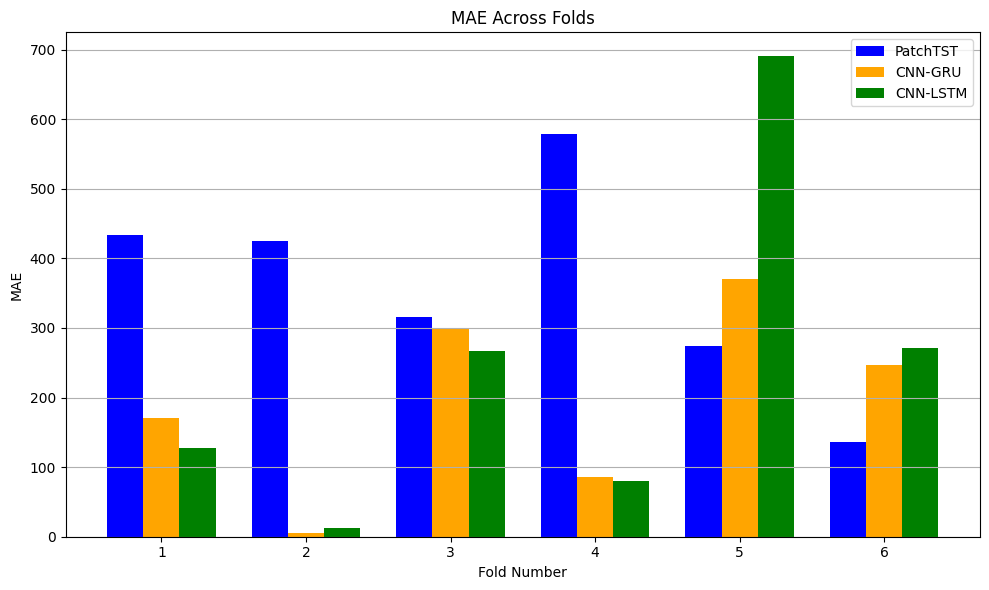

In [91]:
plot_model_scores_grouped_bar(modelScores, 'MAE')

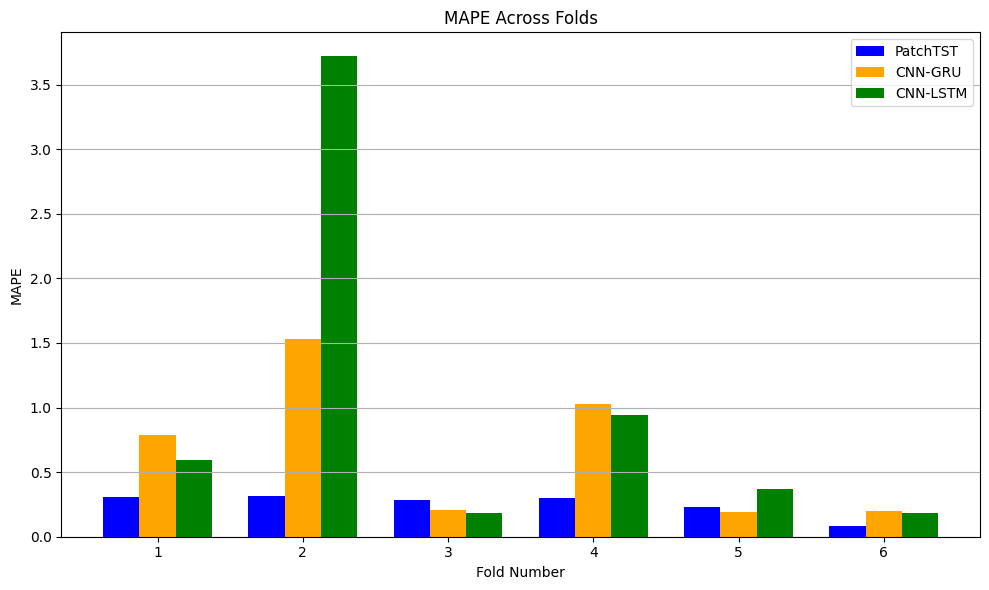

In [92]:
plot_model_scores_grouped_bar(modelScores, 'MAPE')

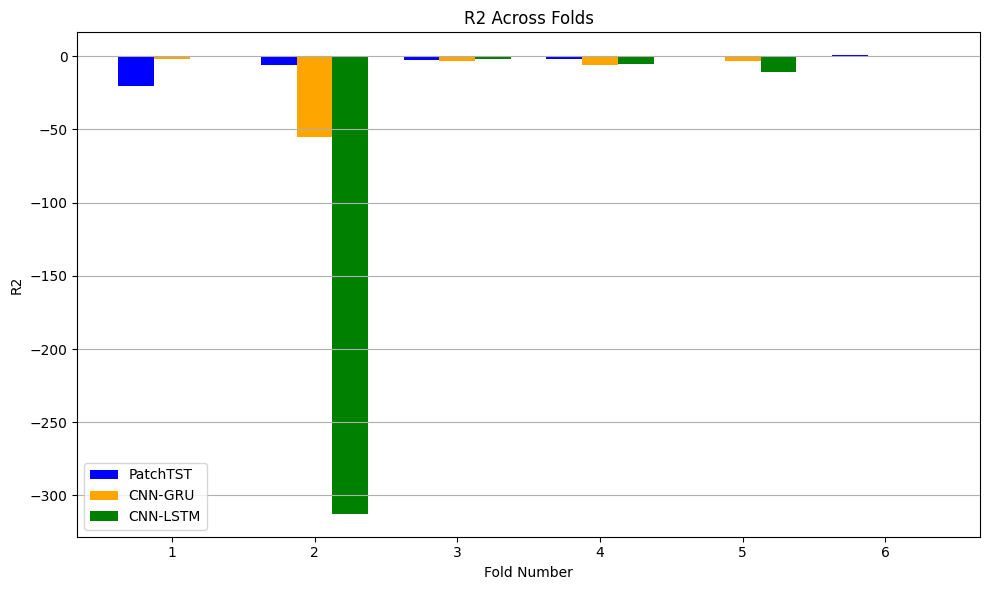

In [93]:
plot_model_scores_grouped_bar(modelScores, 'R2')

### Future Forecast Visualization

In [94]:
forecastDF.reset_index(drop=True)

ds     PatchTST      CNN-GRU     CNN-LSTM
0 2023-01-01 00:00:00  1744.601562  1615.736328  1046.065552
1 2023-01-01 00:10:00  1702.620361  1606.956177  1064.691650
2 2023-01-01 00:20:00  1761.559204  1596.229248  1086.014526
3 2023-01-01 00:30:00  1772.298828  1602.355957  1062.407471
4 2023-01-01 00:40:00  1718.960938  1621.326172  1020.917419
5 2023-01-01 00:50:00  1643.318359  1583.808960  1019.775696

In [95]:
def plot_combined_forecast(histDF, forecastDF, num_rows):
    """
    Combines the last specified number of rows from the historical dataset with the forecasted data
    and plots the actual vs forecasted values from two models.

    Parameters:
    - histDF: DataFrame containing historical data with columns ['ds', 'actualPastData'].
    - forecastDF: DataFrame containing forecasted data with columns ['ds', 'PatchTST', 'CNN-GRU'].
    - num_rows: The number of rows to select from the historical data.

    Returns:
    - None: The function displays a line chart.
    """

    histDF = histDF.rename(columns={'# Date and time': 'ds'})

    # Select the last num_rows from the historical data
    histDF_selected = histDF.tail(num_rows)

    # Combine historical data with forecast data
    combinedDF = pd.concat([histDF_selected, forecastDF], ignore_index=True)

    # Plot the actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(combinedDF['ds'], combinedDF[tarTurbine], label='Historical Data', marker='o', linestyle='-')
    plt.plot(combinedDF['ds'], combinedDF['PatchTST'], label='PatchTST Forecast', marker='x', linestyle='--')
    plt.plot(combinedDF['ds'], combinedDF['CNN-GRU'], label='CNN-GRU Forecast', marker='s', linestyle='-.')
    plt.plot(combinedDF['ds'], combinedDF['CNN-LSTM'], label='CNN-LSTM Forecast', marker='D', linestyle='-.')

    plt.title('Actual vs Day-ahead Forecasted Values')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

histDF = tsDF[['# Date and time', tarTurbine]]

# Plotting the combined data with the last 4 rows of historical data
plot_combined_forecast(histDF, forecastDF, num_rows=20)